<a href="https://colab.research.google.com/github/deepw02/comp3931-sc20dpw/blob/main/pm_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process Mining/Machine Learning to Predict Diagnosis ICD codes


In [ ]:
!pip install -U pm4py

### Authentication & Connecting to MIMIC-III

In [ ]:
from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

import pandas as pd
import numpy as np
import sys
import pm4py

from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split

auth.authenticate_user()
client = bigquery.Client(project='physionet-data-369222')
drive.mount('drive')

### Load Dataframes from Google Drive

In [71]:
cardiovascular = pd.read_csv('drive/My Drive/comp3931-sc20dpw/cardiovascular.csv')
filtered_cardiovascular = pd.read_csv('drive/My Drive/comp3931-sc20dpw/filtered_cardiovascular.csv')
admissions = pd.read_csv('drive/My Drive/comp3931-sc20dpw/admissions.csv')
discharges = pd.read_csv('drive/My Drive/comp3931-sc20dpw/discharges.csv')
procedures = pd.read_csv('drive/My Drive/comp3931-sc20dpw/procedures.csv')
freq_procedures = pd.read_csv('drive/My Drive/comp3931-sc20dpw/freq_procedures.csv')
labtests = pd.read_csv('drive/My Drive/comp3931-sc20dpw/labtests.csv')
freq_labtests = pd.read_csv('drive/My Drive/comp3931-sc20dpw/freq_labtests.csv')

event_log = pd.read_csv('drive/My Drive/comp3931-sc20dpw/event_log.csv')
event_log['timestamp'] = event_log[['timestamp']].apply(pd.to_datetime)

feature_data = pd.read_csv('drive/My Drive/comp3931-sc20dpw/feature_data.csv')
target_data = pd.read_csv('drive/My Drive/comp3931-sc20dpw/target_data.csv')

hadm_all = tuple((filtered_cardiovascular.hadm_id.tolist()))
hadm_unique = hadm_all
freq_procedures_list = freq_procedures.label.tolist()
freq_labtests_list = freq_labtests.label.tolist()

### Function & Class Definitions

In [ ]:
# Function to filter out records where age > 100 during admission

def filter_age(df):

  filter_age_query = (f'''
    SELECT
      hadm_id
    FROM
      physionet-data.mimiciii_clinical.admissions,
      physionet-data.mimiciii_clinical.patients
    WHERE
      admissions.subject_id = patients.subject_id AND
      hadm_id in {tuple(df.hadm_id.tolist())} AND
      DATE_DIFF(admittime, dob, year) <= 100
  ''')

  result = client.query(filter_age_query).to_dataframe()

  return df[df.hadm_id.isin(result.hadm_id)]

In [ ]:
# Function to filter out records that have don't include any procedures

def filter_procedures(df):
   
  filter_procedures_query = (f'''
    SELECT
      hadm_id
    FROM
      physionet-data.mimiciii_clinical.procedureevents_mv
    WHERE
      hadm_id in {tuple(df.hadm_id.tolist())}
    GROUP BY
      hadm_id
  ''')
  
  result = client.query(filter_procedures_query).to_dataframe()

  return df[df.hadm_id.isin(result.hadm_id)]

In [ ]:
# Function to filter out records that have discharge/death before admission

def filter_discharges(df):

  fiter_discharges_query = (f'''
  SELECT 
    hadm_id
  FROM
    physionet-data.mimiciii_clinical.admissions
  WHERE
    hadm_id in {tuple(df.hadm_id.tolist())} AND
    dischtime <= admittime
  ''')

  result = client.query(fiter_discharges_query).to_dataframe()

  return df[~df.hadm_id.isin(result.hadm_id)]

In [ ]:
# CODE TAKEN FROM COMP3611-ML_Pipeline_Part_2.ipynb
# Select columns from dataframe needed for preprocessing

class DataFrameSelector(BaseEstimator):
    
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

### Event Log Creation

In [ ]:
# Extracting subject_id, hadm_id & ICD-9 codes of cardiovascular patients

cardiovascular_query = ('''
  SELECT
    hadm_id,
    subject_id,
    icd9_code
  FROM
    physionet-data.mimiciii_clinical.diagnoses_icd
  WHERE
    icd9_code BETWEEN '390%' AND '459%' AND
    seq_num = 1
''')

cardiovascular = client.query(cardiovascular_query).to_dataframe()

cardiovascular['icd9_code'] = cardiovascular[['icd9_code']].apply(pd.to_numeric)

In [ ]:
# Filter cardiovascular patient records

# Remove records with abnormal ages
filtered_cardiovascular = filter_age(cardiovascular)

# Remove records without any procedures
filtered_cardiovascular = filter_procedures(filtered_cardiovascular)

# Remove records with death/discharge before admission
filtered_cardiovascular = filter_discharges(filtered_cardiovascular)

# Reset dataframe index
filtered_cardiovascular = filtered_cardiovascular.reset_index()

In [ ]:
# No repetitions
hadm_all = tuple((filtered_cardiovascular.hadm_id.tolist()))

# DO I NEED SUBJECT IDS?
# Contains repetitions
# subject_all = tuple(set(filtered_cardiovascular.subject_id.tolist()))

# hadm_random
# subject_random - AGAIN DO I NEED SUBJECT IDS?

hadm_unique = hadm_all
# subject_unique = subject_all

In [ ]:
# Creating admissions event log

admissions_query = (f'''
  SELECT 
    hadm_id,
    "Admission" as event,
    admittime as timestamp,
    admission_type,
    DATE_DIFF(admittime, dob, year) as age,
    gender
  FROM
    physionet-data.mimiciii_clinical.admissions,
    physionet-data.mimiciii_clinical.patients
  WHERE
    hadm_id IN {hadm_unique} AND
    admissions.subject_id = patients.subject_id
''')

admissions = client.query(admissions_query).to_dataframe()

In [ ]:
# Creating discharge/death event log

discharges_query = (f'''
    SELECT
      hadm_id,
      IF(deathtime IS NOT NULL, "Death", "Discharge") as event,
      dischtime as timestamp,
      IF(deathtime IS NOT NULL, 1, 0) as expire_flag
    FROM 
      physionet-data.mimiciii_clinical.admissions
    WHERE
    hadm_id IN {hadm_unique}
''')

discharges = client.query(discharges_query).to_dataframe()

In [ ]:
# Query to find n most frequent procedures conducted on cardiovascular patients

num_procedures = 3

freq_procedures_query = (f'''
  SELECT
    p.itemid,
    COUNT(*) as count_procedures,
    LOWER(REPLACE(label, ' ', '_')) as label
  FROM
    physionet-data.mimiciii_clinical.procedureevents_mv as p,
    physionet-data.mimiciii_clinical.d_items as d
  WHERE
    hadm_id in {hadm_unique} AND
    d.itemid = p.itemid
  GROUP BY
    p.itemid,
    label
  ORDER BY
    count_procedures DESC
  LIMIT
    {num_procedures}
''')

freq_procedures = client.query(freq_procedures_query).to_dataframe()

In [ ]:
# Creating procedures event log

procedures_query = (f'''
    SELECT
      hadm_id,
      "Procedure" as event,
      starttime as timestamp,
      LOWER(REPLACE(label, ' ', '_')) as label
    FROM
      physionet-data.mimiciii_clinical.procedureevents_mv as p,
      physionet-data.mimiciii_clinical.d_items as d
    WHERE
      hadm_id in {hadm_unique} AND
      p.itemid in {tuple(freq_procedures.itemid.tolist())} AND
      d.itemid = p.itemid
''')

procedures = client.query(procedures_query).to_dataframe()

In [ ]:
# Query to find n most frequent lab tests conducted on cardiovascular patients

num_labtests = 2

freq_labtests_query = (f'''
  SELECT
    lab.itemid,
    COUNT(*) as count_labtests,
    LOWER(REPLACE(label, ' ', '_')) as label
  FROM
    physionet-data.mimiciii_clinical.labevents as lab,
    physionet-data.mimiciii_clinical.d_labitems as d
  WHERE
    hadm_id in {hadm_unique} AND
    lab.itemid = d.itemid
  GROUP BY
    lab.itemid,
    label
  ORDER BY
    count_labtests DESC
  LIMIT
    {num_labtests}
''')

freq_labtests = client.query(freq_labtests_query).to_dataframe()

In [ ]:
# Creating lab tests event log

labtests_query = (f'''
  SELECT
    hadm_id,
    "Labtest" as event,
    charttime as timestamp,
    LOWER(REPLACE(label, ' ', '_')) as label,
    IF(FLAG = "abnormal", "abnormal", "normal") as flag
  FROM
    physionet-data.mimiciii_clinical.labevents as lab,
    physionet-data.mimiciii_clinical.d_labitems as d
  WHERE
    hadm_id IN {hadm_unique} AND
    lab.itemid = d.itemid AND
    lab.itemid IN {tuple(freq_labtests.itemid.tolist())} AND
    valuenum IS NOT NULL
''')

labtests = client.query(labtests_query).to_dataframe()

### Combining Event Logs

In [ ]:
# Checking if admissions & discharges table have hadm_id in the same order

def corr_check():

  if len(admissions) != len(discharges):
    return False

  for i in range(len(admissions)):
    if admissions.iloc[i].hadm_id != discharges.iloc[i].hadm_id:
      return False

  return True

corr = corr_check()

if not corr:
  sys.exit()

In [77]:
event_log = pd.concat([admissions, procedures, labtests, discharges], ignore_index=True)

event_log['timestamp'] = event_log[['timestamp']].apply(pd.to_datetime)

event_log.sort_values(['hadm_id', 'timestamp'], inplace=True)

event_log.reset_index(drop=True, inplace=True)

hadm_ordered = event_log['hadm_id'].unique().tolist()

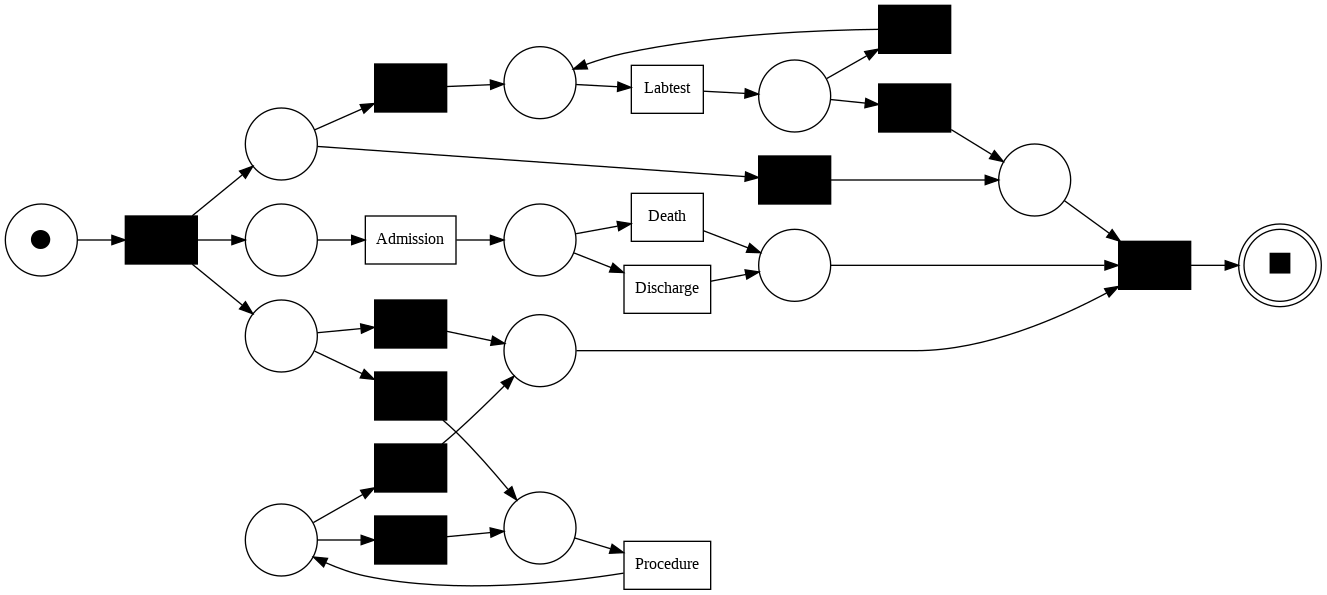

In [78]:
# Discovering initial petri net

for_discovery = event_log[['hadm_id', 'event', 'timestamp']].copy()
for_discovery = for_discovery.astype({'hadm_id':'string', 'event':'string', 'timestamp':'datetime64'})
for_discovery.rename(columns={'hadm_id':'case:concept:name', 'event':'concept:name', 'timestamp':'time:timestamp'}, inplace=True)

net, initial_mark, final_mark = pm4py.discover_petri_net_inductive(for_discovery)
pm4py.view_petri_net(net, initial_mark, final_mark)

In [79]:
# Removing events after discharge/death

discharge_indices = event_log.index[(event_log['event'] == 'Discharge') | (event_log['event'] == 'Death')].tolist()

# hadm_ordered & discharge_indices SHOULD BE of same length
if len(discharge_indices) != len(hadm_ordered):
  sys.exit()

# Storing index of discharge/death corresponding to hadm_id
discharge_dict = {}
for i in range(len(hadm_ordered)):
  discharge_dict[hadm_ordered[i]] = discharge_indices[i]


offset = 1
mask = [True for i in range(len(event_log))]

# Building mask to drop rows after death/discharge
for hadm_id in discharge_dict:
  offset = 1
  
  while True:
    index = discharge_dict[hadm_id] + offset
    if index not in event_log.index:
      break

    row = event_log.loc[index]

    if row['hadm_id'] == hadm_id:
      mask[index] = False
      offset += 1
    else:
      break

  continue

# Applying mask to event log and resetting index
event_log = event_log[mask]
event_log.reset_index(drop=True, inplace=True)

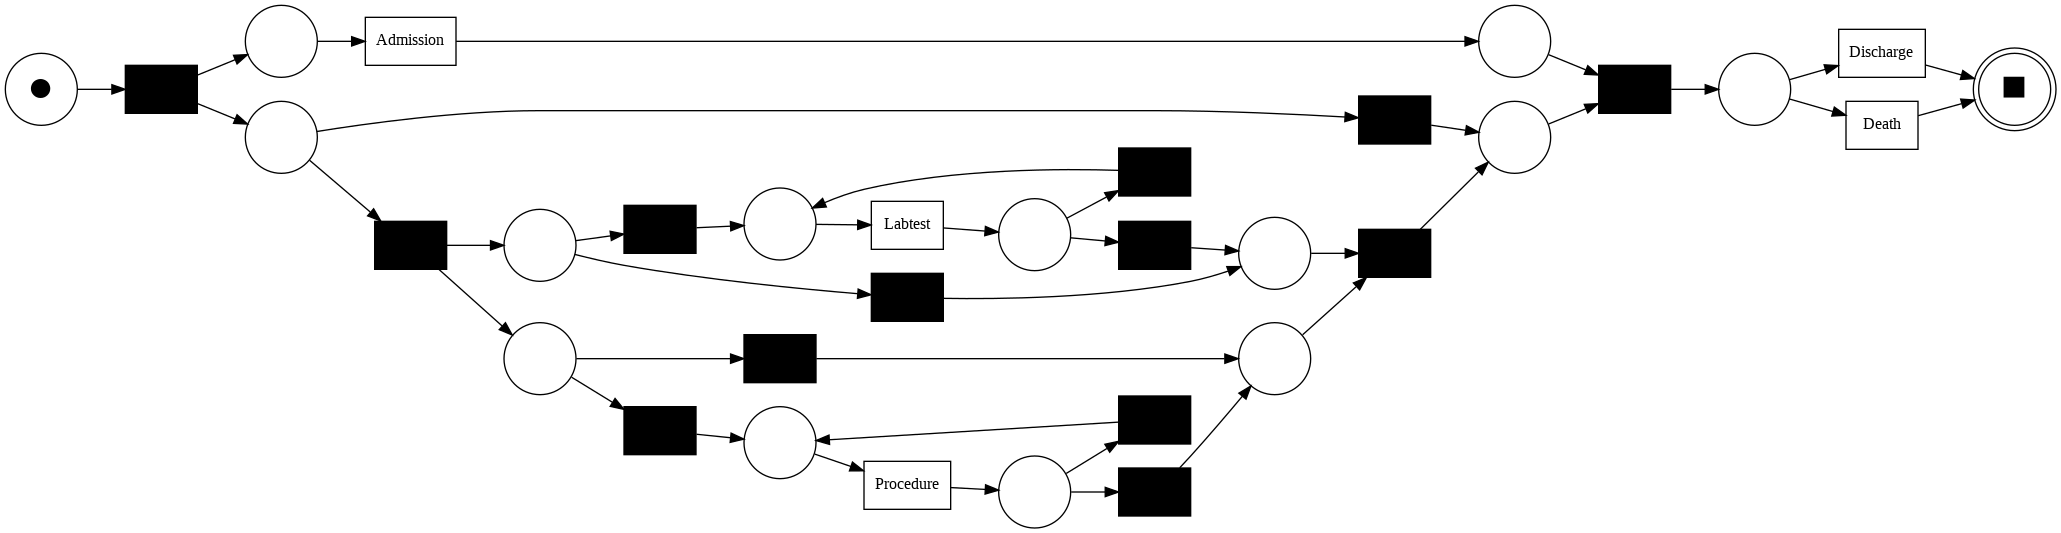

In [80]:
# Discovering petri net after removing events after death/discharge

for_discovery = event_log[['hadm_id', 'event', 'timestamp']].copy()
for_discovery = for_discovery.astype({'hadm_id':'string', 'event':'string', 'timestamp':'datetime64'})
for_discovery.rename(columns={'hadm_id':'case:concept:name', 'event':'concept:name', 'timestamp':'time:timestamp'}, inplace=True)

net, initial_mark, final_mark = pm4py.discover_petri_net_inductive(for_discovery)
pm4py.view_petri_net(net, initial_mark, final_mark)

In [84]:
# Counting procedures and labtests for traces with time in event log

for procedure in freq_procedures_list:
  event_log[f'count_{procedure}'] = 0

for labtest in freq_labtests_list:
  event_log[f'count_normal_{labtest}'] = 0
  event_log[f'count_abnormal_{labtest}'] = 0

temp_event_log = pd.DataFrame()

count_procedures = {}
count_labtests = {}

# Count for every hadm_id
for hadm_id in hadm_ordered:

  for procedure in freq_procedures_list:
    count_procedures[f'count_{procedure}'] = 0
  for labtest in freq_labtests_list:
    count_labtests[f'count_normal_{labtest}'] = 0
    count_labtests[f'count_abnormal_{labtest}'] = 0

  records = event_log.loc[event_log['hadm_id'] == hadm_id]

  # Iterate over all events corresponding to a patient
  for index, row in records.iterrows():
    if row['label'] in freq_procedures_list:
      count_procedures[f"count_{row['label']}"] += 1

    if row['label'] in freq_labtests_list:
      count_labtests[f"count_{row['flag']}_{row['label']}"] += 1
    
    for procedure in freq_procedures_list:
      records.at[index, f'count_{procedure}'] = count_procedures[f'count_{procedure}']

    for labtest in freq_labtests_list:
      records.at[index, f'count_normal_{labtest}'] = count_labtests[f'count_normal_{labtest}']
      records.at[index, f'count_abnormal_{labtest}'] = count_labtests[f'count_abnormal_{labtest}']

  temp_event_log = pd.concat([temp_event_log, records])

event_log = temp_event_log.copy()

In [86]:
# Removing events before admission

admission_indices = event_log.index[(event_log['event'] == 'Admission')].tolist()

# hadm_ordered & admission_indices SHOULD BE of same length
if len(admission_indices) != len(hadm_ordered):
  sys.exit()

# Storing index of discharge/death corresponding to hadm_id
admission_dict = {}
for i in range(len(hadm_ordered)):
  admission_dict[hadm_ordered[i]] = admission_indices[i]

offset = 1
mask = [True for i in range(len(event_log))]

# Building mask to drop rows before admission
for hadm_id in admission_dict:
  offset = 1

  while True:
    index = admission_dict[hadm_id] - offset

    if index not in event_log.index:
      break

    row = event_log.loc[index]

    if row['hadm_id'] == hadm_id:
      mask[index] = False
      offset += 1
    else:
      break

  continue

# Applying mask to event log and resetting index
event_log = event_log[mask]
event_log.reset_index(drop=True, inplace=True)

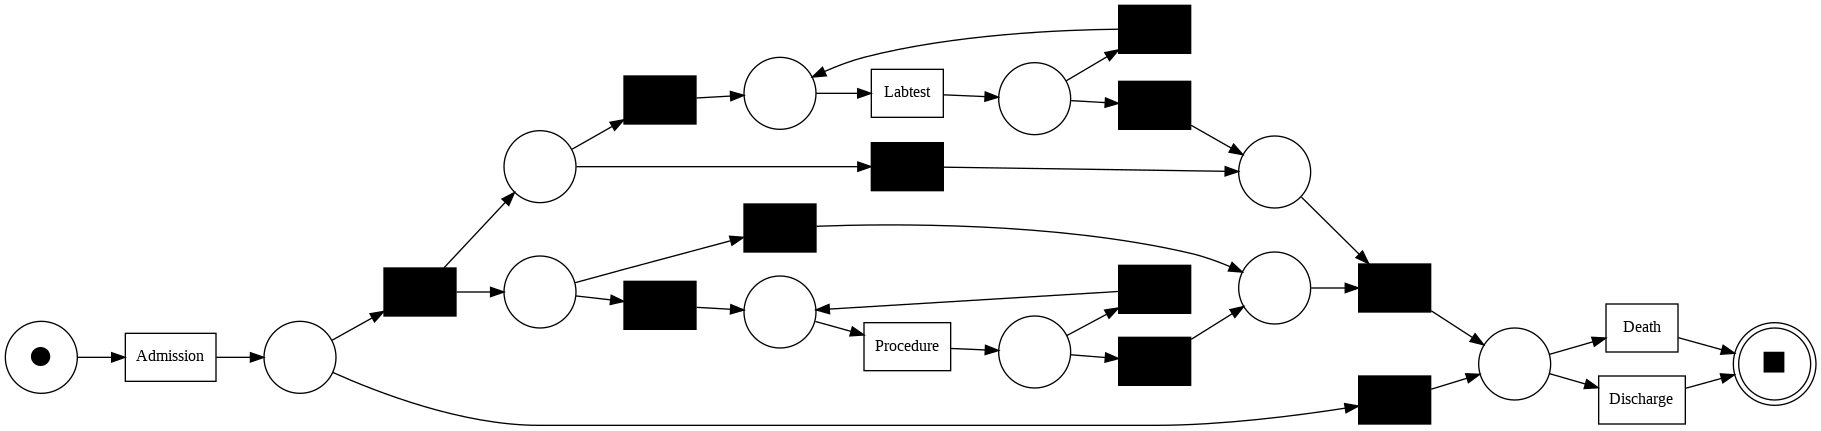

In [87]:
# Discovering petri net after removing events before admission

for_discovery = event_log[['hadm_id', 'event', 'timestamp']].copy()
for_discovery = for_discovery.astype({'hadm_id':'string', 'event':'string', 'timestamp':'datetime64'})
for_discovery.rename(columns={'hadm_id':'case:concept:name', 'event':'concept:name', 'timestamp':'time:timestamp'}, inplace=True)

net, initial_mark, final_mark = pm4py.discover_petri_net_inductive(for_discovery)
pm4py.view_petri_net(net, initial_mark, final_mark)

In [89]:
# Copying repetetive data

repetitive_list = ['admission_type', 'age', 'gender']

for hadm_id in hadm_ordered:
  mask = event_log.hadm_id == hadm_id
  for column in repetitive_list:
    event_log.loc[mask, column] = event_log[mask].iloc[0][column]

In [ ]:
# Keep this cell it's very useful

count = 0
myset = set()

for hadm_id in hadm_ordered:
  records = event_log.loc[event_log['hadm_id'] == hadm_id]
  # if records.iloc[-1].loc['event'] != 'Discharge' and records.iloc[-1].loc['event'] != 'Death':
  if records.iloc[0].loc['event'] != 'Admission':

    # count += 1

    # record_admittime = records.loc[records['event'] == "Admission"].iloc[0].loc["timestamp"]
    # record_firstlabtime = records.iloc[0].loc["timestamp"]

    # time_delta = record_admittime.date() - record_firstlabtime.date()
    # time_delta = record_admittime.hour - record_firstlabtime.hour

    # time_deltas.append(time_delta.days)

    # display(records)

    # # print(time_delta)
    # print("---------")
    # print("")

    # if records.iloc[0].loc['event'] not in myset:
    myset.add(records.iloc[0].loc['event'])
    #   display(records)
    #   print("---------")

# print(time_deltas)



# print(count)

for ele in myset:
  print(ele)
  print("---------")
  

# count = 0

# for hadm_id in hadm_ordered:
#   records = event_log.loc[event_log['hadm_id'] == hadm_id]

#   a_type = records.iloc[0].loc['admission_type']
#   age = records.iloc[0].loc['age']
#   gender = records.iloc[0].loc['gender']

#   print(a_type)
#   print(age)
#   print(gender)
#   print("-----")

#   if count == 3:
#     break
#   count += 1


# display(event_log.head(50))

### Old Cells

In [ ]:
# Adding information from admissions & discharges

# feature_data = pd.merge(admissions[['hadm_id', 'timestamp', 'admission_type', 'age', 'gender']], discharges[['hadm_id', 'timestamp', 'expire_flag']], on=['hadm_id'], how='inner')

# feature_data['timestamp_x'] = feature_data[['timestamp_x']].apply(pd.to_datetime)
# feature_data['timestamp_y'] = feature_data[['timestamp_y']].apply(pd.to_datetime)


# # Keeping only hour of admission & discharge
# feature_data['timestamp_x'] = feature_data['timestamp_x'].dt.hour
# feature_data['timestamp_y'] = feature_data['timestamp_y'].dt.hour

# feature_data.rename(columns={"timestamp_x": "admit_hour", "timestamp_y": "disch_hour"}, inplace=True, errors="raise")

In [ ]:
# Storing order of hadm_id's in feature_data in a list & dropping from table

# hadm_ordered = feature_data.hadm_id.tolist()

# if 'hadm_id' in feature_data.columns:
#   feature_data.drop(columns=['hadm_id'], inplace=True)

In [ ]:
# Adding information from procedures

# procedure_count = []

# for i in range(len(freq_procedures)):
#     procedure_count.append([])

# for hadm_id in hadm_ordered:

#   records = procedures.loc[procedures['hadm_id'] == hadm_id]
#   record_count = {}
  
#   for label in freq_procedures.label.tolist():
#     record_count[label] = 0

#   for _, row in records.iterrows():
#     record_count[row['label']] += 1

#   i = 0
#   for label in freq_procedures.label.tolist():
#     procedure_count[i].append(record_count[label])
#     i += 1  

# i = 0
# for label in freq_procedures.label.tolist():
#   feature_data[f'count_{label}'] = procedure_count[i]
#   i += 1

In [ ]:
# Adding information from labtests

# labtest_count = []

# for i in range(len(freq_labtests)):
#     labtest_count.append([])
#     labtest_count.append([])

# for hadm_id in hadm_ordered:

#   records = labtests.loc[labtests['hadm_id'] == hadm_id]
#   record_count = {}

#   for label in freq_labtests.label.tolist():
#     record_count[f'{label}_abnormal'] = 0
#     record_count[f'{label}_normal'] = 0

#   for _, row in records.iterrows():
#     record_count[f"{row['label']}_{row['flag']}"] += 1

#   i = 0
#   for label in freq_labtests.label.tolist():
#     labtest_count[i].append(record_count[f'{label}_abnormal'])
#     labtest_count[i+1].append(record_count[f'{label}_normal'])
#     i += 2  
  
# i = 0
# for label in freq_labtests.label.tolist():
#   feature_data[f'count_abnormal_{label}'] = labtest_count[i]
#   feature_data[f'count_normal_{label}'] = labtest_count[i+1]
#   i += 2  

### Preparing Target Data

In [ ]:
# Creating dataframe of ICD9-codes in required order

target_data = pd.DataFrame({'icd9_code': pd.Series(dtype=int)})

i = 0
for hadm_id in hadm_ordered:
  target_data.loc[i] = filtered_cardiovascular.loc[filtered_cardiovascular['hadm_id'] == hadm_id].iloc[0]['icd9_code']
  i += 1

# Keeping only first 3 digits of code
target_data['icd9_code'] = target_data['icd9_code'].astype(str).str[:3].astype(int)

### Define Preprocessing Pipelines

In [ ]:
# Defining numerical & categorical features
cat_features = ['admission_type', 'gender']
num_features = [feature for feature in list(feature_data) if feature not in cat_features]


# Creating numerical & categorical pipelines & combining the two
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_features)),
    ('one_hot', OneHotEncoder())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline)
])

### Train-Test Split & Apply Pipeline

In [ ]:
train_features, test_features = train_test_split(feature_data, test_size=0.3, random_state=47)
train_targets, test_targets = train_test_split(target_data, test_size=0.3, random_state=47) 

train_features_prep = full_pipeline.fit_transform(train_features)
test_features_prep = full_pipeline.fit_transform(test_features)

### Train Model (Linear Regressor)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()
lin_reg.fit(train_features_prep, train_targets)

LinearRegression()

### Evaluate on Test Set

In [ ]:
from sklearn.metrics import mean_squared_error

test_predictions = lin_reg.predict(test_features_prep)


lin_mse = mean_squared_error(test_targets, test_predictions)
lin_rmse=np.sqrt(lin_mse)
print(lin_rmse)

11.409074995213295


### Throwaway cell

In [90]:
# CELL FOR OUTPUTS

display(event_log.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181713 entries, 0 to 181712
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   hadm_id                    181713 non-null  int64         
 1   event                      181713 non-null  object        
 2   timestamp                  181713 non-null  datetime64[ns]
 3   admission_type             181713 non-null  object        
 4   age                        181713 non-null  float64       
 5   gender                     181713 non-null  object        
 6   label                      168389 non-null  object        
 7   flag                       143009 non-null  object        
 8   expire_flag                6662 non-null    float64       
 9   count_chest_x-ray          181713 non-null  int64         
 10  count_20_gauge             181713 non-null  int64         
 11  count_ekg                  181713 non-null  int64   

None

### Saving Dataframes to Google Drive

In [ ]:
# Saving dataframes to Google Drive

cardiovascular.to_csv('cardiovascular.csv', index=False)
!cp cardiovascular.csv 'drive/My Drive/comp3931-sc20dpw'

filtered_cardiovascular.to_csv('filtered_cardiovascular.csv', index=False)
!cp filtered_cardiovascular.csv 'drive/My Drive/comp3931-sc20dpw'

admissions.to_csv('admissions.csv', index=False)
!cp admissions.csv 'drive/My Drive/comp3931-sc20dpw'

discharges.to_csv('discharges.csv', index=False)
!cp discharges.csv 'drive/My Drive/comp3931-sc20dpw'

procedures.to_csv('procedures.csv', index=False)
!cp procedures.csv 'drive/My Drive/comp3931-sc20dpw'

freq_procedures.to_csv('freq_procedures.csv', index=False)
!cp freq_procedures.csv 'drive/My Drive/comp3931-sc20dpw'

labtests.to_csv('labtests.csv', index=False)
!cp labtests.csv 'drive/My Drive/comp3931-sc20dpw'

freq_labtests.to_csv('freq_labtests.csv', index=False)
!cp freq_labtests.csv 'drive/My Drive/comp3931-sc20dpw'

event_log.to_csv('event_log.csv', index=False)
!cp event_log.csv 'drive/My Drive/comp3931-sc20dpw'

if 'hadm_id' not in feature_data.columns:
  feature_data.insert(loc=0, column='hadm_id', value=hadm_ordered)
feature_data.to_csv('feature_data.csv', index=False)
!cp feature_data.csv 'drive/My Drive/comp3931-sc20dpw'

target_data.to_csv('target_data.csv', index=False)
!cp target_data.csv 'drive/My Drive/comp3931-sc20dpw'